In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as interp
# import cmocean
import spharm as ps
from pathlib import Path
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from scipy.special import roots_legendre
import cmocean


In [2]:
lmax=256 #Our maximum degree used in the SH transform
lreturn=16 #The maximum degree we truncate to for the inverse SH transform
a = 6.371e6     #earth radius (meters)


#################### LOAD DATA
mf1 = Path("./etopo_ice_15.npy")
mf2 = Path("./etopo_ice_15.txt")

if mf1.is_file():
    etopo = np.load('etopo_ice_15.npy')

elif mf2.is_file():
    etopo = np.loadtxt('etopo_ice_15.txt') #lon, lat, topography
  
  #numpy .npy binary format example
    np.save('etopo_ice_15.npy',etopo)

else:
    print("Can not find etopo file")

############## Reshape etopo
num1 = np.unique(etopo[:,0]).size
num2 = np.unique(etopo[:,1]).size

lon2 = np.reshape(etopo[:,0],(num1,num2)).T
lat2 = np.reshape(etopo[:,1],(num1,num2)).T
topo2 = np.reshape(etopo[:,2],(num1,num2)).T

topo_interp = interp.interp2d(lon2[1,:],lat2[:,1],topo2)

In [5]:
def make_glq_grid(lmax):
    
    nlat, nlon = lmax, lmax * 2
    zero, w = roots_legendre(lmax)
    
    longlq = np.array([360 * i/nlon for i in range(nlon)])
    latglq = np.array([np.arcsin(zero[i]) * 180/np.pi for i in range(nlat)])
    
    return longlq, latglq,  nlat, nlon

In [17]:
############## Construct gauss legendre grid
print("Generating GLQ grid ...")

longlq, latglq, nlat, nlon = make_glq_grid(lmax)


############## Interplate data onto grid
print("Interpolating data onto GLQ grid ...")
topoglq2 = topo_interp(longlq,latglq)


############## Spherical harmonic transform

sph = ps.Spharmt(nlon, nlat, rsphere=a, gridtype='gaussian', legfunc='stored')
cilm = sph.grdtospec(topoglq2)

############## Inverse Spherical harmonic transform

gridglq = sph.spectogrd(cilm)

Generating GLQ grid ...
Interpolating data onto GLQ grid ...


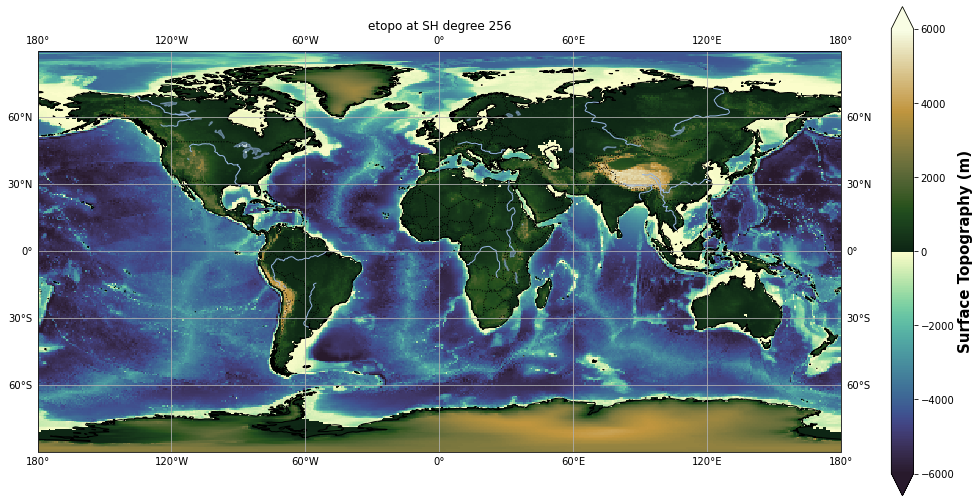

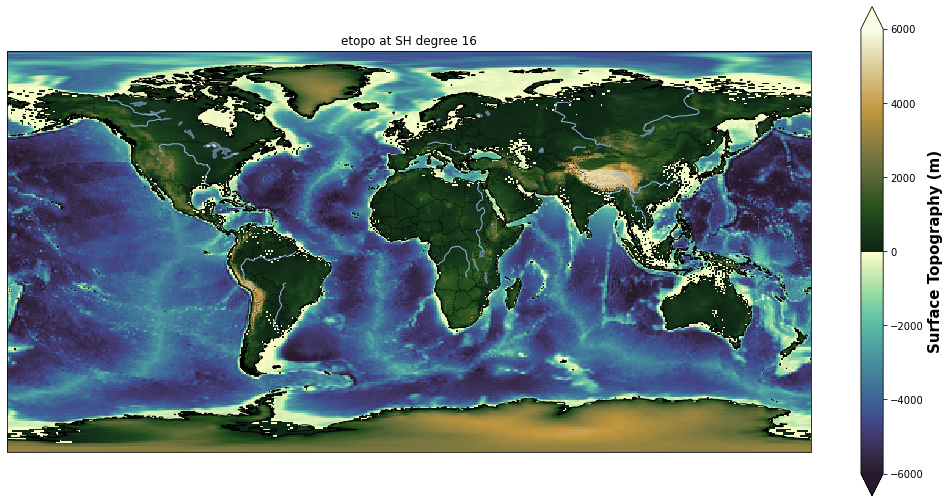

In [18]:
# ############## Plot results
# print("Plotting ...")

##Initial topography on GLQ grid
f1 = plt.figure(figsize=(18,12))
# add a subplot
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# set the extent (you will need to change this for your problem set)
# ax1.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())


def add_features(ax):
    
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    return ax

ax1 = add_features(ax1)

# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

t1 = ax1.pcolormesh(longlq,latglq,topoglq2,cmap = cmocean.cm.topo, vmin=-6000, vmax=6000)

cb = f1.colorbar(t1, ax=ax1, shrink=0.75, extend='both')
cb.set_label(label='Surface Topography (m)',size=15,weight='bold')
plt.title('etopo at SH degree ' + str(lmax))


#Final topography on GLQ grid after truncation
f2 = plt.figure(figsize=(18,12))
ax2 = f2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2 = add_features(ax2)


#To deal with complex numbers in gridglq
tmp = np.sign(gridglq).real*np.abs(gridglq)

t2 = ax2.pcolormesh(longlq,latglq,tmp,cmap = cmocean.cm.topo, vmin=-6000, vmax=6000)

cb2 = f2.colorbar(t2, ax=ax2, shrink=0.75, extend='both')
cb2.set_label(label='Surface Topography (m)',size=15,weight='bold')
plt.title('etopo at SH degree ' + str(lreturn))

plt.show()